# Stellar Classification  

| Column Name | Description |
|-------------|-------------|
| `obj_ID` | Object Identifier, the unique value that identifies the object in the image catalog used by the CAS |
| `alpha` | Right Ascension angle (at J2000 epoch) |
| `delta` | Declination angle (at J2000 epoch) |
| `u` | Ultraviolet filter in the photometric system |
| `g` | Green filter in the photometric system |
| `r` | Red filter in the photometric system |
| `i` | Near Infrared filter in the photometric system |
| `z` | Infrared filter in the photometric system |
| `run_ID` | Run Number used to identify the specific scan |
| `rerun_ID` | Rerun Number to specify how the image was processed |
| `cam_col` | Camera column to identify the scanline within the run |
| `field_ID` | Field number to identify each field |
| `spec_obj_ID` | Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class) |
| `class` | Object class (galaxy, star, or quasar object) |
| `redshift` | Redshift value based on the increase in wavelength |
| `plate` | Plate ID, identifies each plate in SDSS |
| `MJD` | Modified Julian Date, used to indicate when a given piece of SDSS data was taken |
| `fiber_ID` | Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation |


In [94]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### Load and exploration of the dataset

In [95]:
filename = 'star_classification.csv'
data = pd.read_csv(filename)
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [96]:
rows,columns = data.shape
print(f"Number of rows/examples: {rows}")
print(f"Number of columns/features: {columns}")

Number of rows/examples: 100000
Number of columns/features: 18


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [98]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
obj_ID,100000.0,1.237665e+18,8.438560e+12,1.237646e+18,1.237659e+18,1.237663e+18,1.237668e+18,1.237681e+18
alpha,100000.0,1.776291e+02,9.650224e+01,5.527828e-03,1.275182e+02,1.809007e+02,2.338950e+02,3.599998e+02
delta,100000.0,2.413530e+01,1.964467e+01,-1.878533e+01,5.146771e+00,2.364592e+01,3.990155e+01,8.300052e+01
u,100000.0,2.198047e+01,3.176929e+01,-9.999000e+03,2.035235e+01,2.217914e+01,2.368744e+01,3.278139e+01
g,100000.0,2.053139e+01,3.175029e+01,-9.999000e+03,1.896523e+01,2.109983e+01,2.212377e+01,3.160224e+01
r,100000.0,1.964576e+01,1.854760e+00,9.822070e+00,1.813583e+01,2.012529e+01,2.104478e+01,2.957186e+01
i,100000.0,1.908485e+01,1.757895e+00,9.469903e+00,1.773228e+01,1.940514e+01,2.039650e+01,3.214147e+01
z,100000.0,1.866881e+01,3.172815e+01,-9.999000e+03,1.746068e+01,1.900460e+01,1.992112e+01,2.938374e+01
run_ID,100000.0,4.481366e+03,1.964765e+03,1.090000e+02,3.187000e+03,4.188000e+03,5.326000e+03,8.162000e+03
rerun_ID,100000.0,3.010000e+02,0.000000e+00,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02


In [99]:
data["class"].value_counts() # class = object class (galaxy, star or quasar object)

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

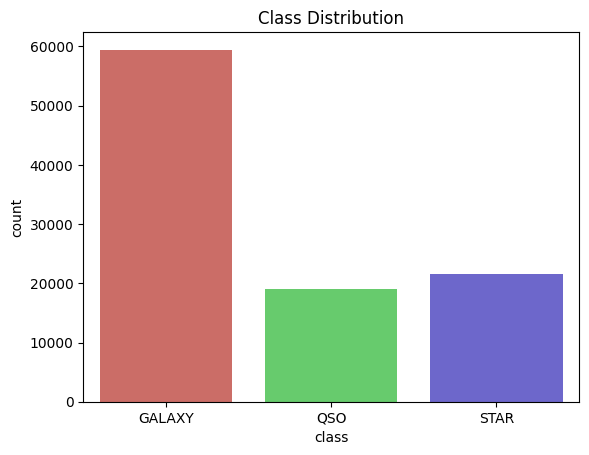

In [100]:
sns.countplot(x="class", data=data, palette="hls")
plt.title("Class Distribution")
plt.show()



We will encode the values of the target variable `class` to integers. 

In [101]:
LE = LabelEncoder()
data["class"] = LE.fit_transform(data["class"])
print("New class values: 0 for GALAXY, 1 for STAR, 2 for QUASAR")
print(data["class"].value_counts())


New class values: 0 for GALAXY, 1 for STAR, 2 for QUASAR
0    59445
2    21594
1    18961
Name: class, dtype: int64


We split the dataset into X and Y, and then into training and testing sets.

In [102]:
X = data.drop("class", axis=1)
Y = data["class"]
X

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,0.455040,6751,56368,470


We split into training and test sets: 80% of the data will be used for training and 20% for testing.

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)